# 3QEUS0 - Sociophysics 1
## A gentle intro to data analysis of pedestrian trajectories

### Contacts:
*   A.Corbetta - a.corbetta@tue.nl
*   C.Pouw     - c.a.s.pouw@tue.nl
*   A.Gabbana  - a.gabbana@tue.nl  


### We assume some basic knowledge of jupyter/python
If that is not the case:

*    [Python for Beginners](https://www.python.org/about/gettingstarted/)
*    [Python for Science](https://scipy-lectures.org/intro/) (including examples for plotting data)
*    [10 minutes to pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html)
*    Books, Youtube tutorials...


### Purpose of this notebook:

*   Getting familiar with Colab
*   Installing and using the sociophysicsdatahandler package to retrieve data
*   A few examples of basic plots

#### First, we need to install the API for accessing the data
Note: If you work in colab you need to perform the installation everytime you start the notebook; if you work offline (jupyter notebook/lab) you need to do this just once

In [10]:
!pip install -q sociophysicsDataHandler

In [20]:
!pip install sociophysicsDataHandler --upgrade

  Created wheel for sociophysicsDataHandler: filename=sociophysicsDataHandler-1.4-py3-none-any.whl size=7762 sha256=06600cea7eb52d64c3736160051b0f9861ad08350fe63e6f6c884b12b5cac6e6
  Stored in directory: /home/pouw/.cache/pip/wheels/38/a7/55/c63a5f4dfa8b3f28324f0c380c83fa1cad3296154610ae6924
Successfully built sociophysicsDataHandler
  Attempting uninstall: sociophysicsDataHandler
    Found existing installation: sociophysicsDataHandler 1.2.5
    Uninstalling sociophysicsDataHandler-1.2.5:
      Successfully uninstalled sociophysicsDataHandler-1.2.5


Import the package.

In [1]:
from sociophysicsDataHandler import SociophysicsDataHandler
dh = SociophysicsDataHandler()

##### If you get an error you need to provide some credentials first. Also see the notebook: `sociophysicsDataHandler.ipynb`.

Follow these steps and run the cell above again.

1. An empty credentials file is created for you. It is called 'auth.txt'.
2. In colab, go to the left panel 'files'. You can change the content by double clicking on it.
3. Paste the acces credentials (specified below) in the file and SAVE the file. (note, from time to me we change the credentials)
````
guest
YDPGL-XREXC-QGMZS-UAKES
````

## Using the sociophysicsDataHandler

We can use the datahandler object to read the data that is provided to you in this course. However, to understand how and which data you can read it is convenient to first list the folders available on the storage. 

The ouput of the cell below shows which folders area available to you. 
 - All the data for the social media/ stocks case can be found in the 'econophysics' folder.
 - The trajectory data for the crowdflow case is separated based on where it is recorded: ehv -> Eindhoven, asdz -> Amsterdam Zuid, and ut -> Utrecht.

In [2]:
folder_path = ''
dh.list_files(folder_path)

targeting path /storage/surfsara/ProRail_USE_LL_data/
Files listed. Accessible as <this-object>.filelist


,path,name,attributes
0,/storage/surfsara/ProRail_USE_LL_data/asdz/,asdz,"{'{DAV:}getlastmodified': 'Mon, 12 Sep 2022 15..."
1,/storage/surfsara/ProRail_USE_LL_data/config/,config,"{'{DAV:}getlastmodified': 'Mon, 12 Sep 2022 15..."
2,/storage/surfsara/ProRail_USE_LL_data/econophy...,econophysics,"{'{DAV:}getlastmodified': 'Mon, 12 Sep 2022 15..."
3,/storage/surfsara/ProRail_USE_LL_data/ehv/,ehv,"{'{DAV:}getlastmodified': 'Thu, 21 Sep 2023 17..."
4,/storage/surfsara/ProRail_USE_LL_data/sync.sh,sync.sh,"{'{DAV:}getlastmodified': 'Wed, 02 Mar 2022 18..."
5,/storage/surfsara/ProRail_USE_LL_data/upload_l...,upload_log.csv,"{'{DAV:}getlastmodified': 'Wed, 13 Oct 2021 10..."
6,/storage/surfsara/ProRail_USE_LL_data/ut/,ut,"{'{DAV:}getlastmodified': 'Tue, 03 Oct 2023 12..."


We can also list the files in subdirectories. For instance, the cell below shows all the files that are recorded on the 28th of April 2023 in Eindhoven. Note that there exists a file for every hour of the day.

In [3]:
folder_path = 'asdz/platform1.1/'
dh.list_files(folder_path)

targeting path /storage/surfsara/ProRail_USE_LL_data/asdz/platform1.1/
Files listed. Accessible as <this-object>.filelist


,path,name,attributes
0,/storage/surfsara/ProRail_USE_LL_data/asdz/pla...,20200701,"{'{DAV:}getlastmodified': 'Wed, 02 Mar 2022 18..."
1,/storage/surfsara/ProRail_USE_LL_data/asdz/pla...,20200702,"{'{DAV:}getlastmodified': 'Wed, 02 Mar 2022 18..."
2,/storage/surfsara/ProRail_USE_LL_data/asdz/pla...,20200703,"{'{DAV:}getlastmodified': 'Wed, 02 Mar 2022 18..."
3,/storage/surfsara/ProRail_USE_LL_data/asdz/pla...,20200704,"{'{DAV:}getlastmodified': 'Wed, 02 Mar 2022 18..."
4,/storage/surfsara/ProRail_USE_LL_data/asdz/pla...,20200705,"{'{DAV:}getlastmodified': 'Wed, 02 Mar 2022 18..."
...,...,...,...
177,/storage/surfsara/ProRail_USE_LL_data/asdz/pla...,20201225,"{'{DAV:}getlastmodified': 'Wed, 02 Mar 2022 18..."
178,/storage/surfsara/ProRail_USE_LL_data/asdz/pla...,20201226,"{'{DAV:}getlastmodified': 'Wed, 02 Mar 2022 18..."
179,/storage/surfsara/ProRail_USE_LL_data/asdz/pla...,20201227,"{'{DAV:}getlastmodified': 'Wed, 02 Mar 2022 18..."
180,/storage/surfsara/ProRail_USE_LL_data/asdz/pla...,20201228,"{'{DAV:}getlastmodified': 'Wed, 02 Mar 2022 18..."


In [4]:
folder_path = 'ehv/platform2.1/20230428/'
dh.list_files(folder_path)

targeting path /storage/surfsara/ProRail_USE_LL_data/ehv/platform2.1/20230428/
Files listed. Accessible as <this-object>.filelist


,path,name,attributes
0,/storage/surfsara/ProRail_USE_LL_data/ehv/plat...,EHV_Platform2.1_2023042800_trajectorie.parquet,"{'{DAV:}getlastmodified': 'Mon, 11 Sep 2023 14..."
1,/storage/surfsara/ProRail_USE_LL_data/ehv/plat...,EHV_Platform2.1_2023042801_trajectorie.parquet,"{'{DAV:}getlastmodified': 'Mon, 11 Sep 2023 14..."
2,/storage/surfsara/ProRail_USE_LL_data/ehv/plat...,EHV_Platform2.1_2023042802_trajectorie.parquet,"{'{DAV:}getlastmodified': 'Mon, 11 Sep 2023 14..."
3,/storage/surfsara/ProRail_USE_LL_data/ehv/plat...,EHV_Platform2.1_2023042803_trajectorie.parquet,"{'{DAV:}getlastmodified': 'Mon, 11 Sep 2023 14..."
4,/storage/surfsara/ProRail_USE_LL_data/ehv/plat...,EHV_Platform2.1_2023042804_trajectorie.parquet,"{'{DAV:}getlastmodified': 'Mon, 11 Sep 2023 14..."
5,/storage/surfsara/ProRail_USE_LL_data/ehv/plat...,EHV_Platform2.1_2023042805_trajectorie.parquet,"{'{DAV:}getlastmodified': 'Mon, 11 Sep 2023 14..."
6,/storage/surfsara/ProRail_USE_LL_data/ehv/plat...,EHV_Platform2.1_2023042806_trajectorie.parquet,"{'{DAV:}getlastmodified': 'Mon, 11 Sep 2023 14..."
7,/storage/surfsara/ProRail_USE_LL_data/ehv/plat...,EHV_Platform2.1_2023042807_trajectorie.parquet,"{'{DAV:}getlastmodified': 'Mon, 11 Sep 2023 14..."
8,/storage/surfsara/ProRail_USE_LL_data/ehv/plat...,EHV_Platform2.1_2023042808_trajectorie.parquet,"{'{DAV:}getlastmodified': 'Mon, 11 Sep 2023 14..."
9,/storage/surfsara/ProRail_USE_LL_data/ehv/plat...,EHV_Platform2.1_2023042809_trajectorie.parquet,"{'{DAV:}getlastmodified': 'Mon, 11 Sep 2023 14..."


We can read the data by providing the correct filename. The cell below shows how to read one of the files.

In [5]:
file_target = "EHV_Platform2.1_2023042808_trajectorie.parquet"
file_path = folder_path + file_target
dh.fetch_prorail_data_from_path(file_path) # Read the data
dh.df.head() # Display first 5 rows

trying to fetch: /storage/surfsara/ProRail_USE_LL_data/ehv/platform2.1/20230428/EHV_Platform2.1_2023042808_trajectorie.parquet
data fetched. Accessible as <this-object>.df


,date_time_utc,tracked_object,x_pos,y_pos,datetime
0,1.682662e+12,13826589,-414.0,27576.0,2023-04-28 08:00:00+02:00
1,1.682662e+12,13826715,-5347.0,19918.0,2023-04-28 08:00:00+02:00
2,1.682662e+12,13826896,-68.0,11596.0,2023-04-28 08:00:00+02:00
3,1.682662e+12,13826897,284.0,11137.0,2023-04-28 08:00:00+02:00
4,1.682662e+12,13826907,-3224.0,6792.0,2023-04-28 08:00:00+02:00


<b>The data has four columns:</b> <br>
- `date_time_utc` = UNIX timestamp in milliseconds since the first of January 1970.<br>
- `tracked_object` = Unique object id <br>
- `x_pos` = x-coordinate in millimeter <br>
- `y_pos` = y-coordinate in millimeter <br>

## Plotting the trajectories

To understand the data we are working with, we create a plot of the individual trajectories. In the cell below we create a subset with 50 trajectories and plot every trajectory with a unique color. 

Tip: The coordinate system (x and y) is arbitrary. To visualize the Eindhoven datatset it is more convenient to swap the x and y coordinates.

In [6]:
# Swap the x and y coordinates
dh.df.rename({'x_pos':'y_pos', 'y_pos':'x_pos'}, axis = 1, inplace = True)

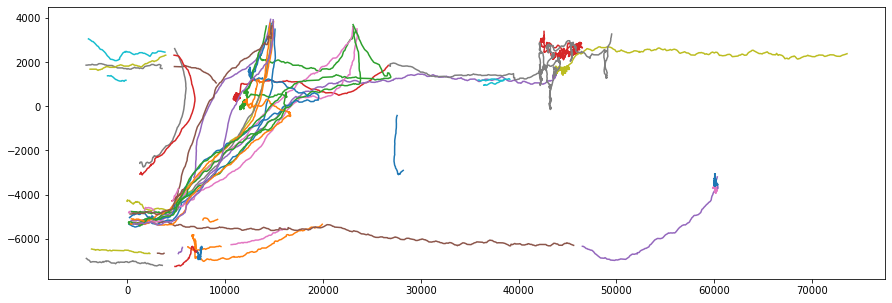

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (15, 5))

# Create a subset with trajectories
Ntrajectories = 50
N_object_ids = dh.df['tracked_object'].unique()[:Ntrajectories]
plot_df = dh.df[dh.df['tracked_object'].isin(N_object_ids)].copy()

# Plot the individual trajectories
plot_df.groupby('tracked_object').apply(lambda x : ax.plot(x.x_pos,x.y_pos));

## Background and configuration

To understand where this data is recorded we would like to read the configuration file and the background image. The configuration file can be read with the `dh.fetch_configuration_data()` method. You need to provide the station abbreviation, the platform number and the date. The date is important because the measurement setups have been changed and recalibrated a couple of times. The background can be read using the information in the configuration file. Below is an example for the Eindhoven trainstation. If you want to use data from Utrecht instead you must change station to `'ut'` and platform number to `'3'`.

In [11]:
configuration = dh.fetch_configuration_data(station = 'ehv', platform_number = '2.1', date = '2023-01-01')

trying to fetch: /storage/surfsara/ProRail_USE_LL_data/ehv/platform2.1/configuration


trying to fetch: /storage/surfsara/ProRail_USE_LL_data/ehv/background_images/EHV.Perron2.1_multisensor.png
background fetched. Accessible as <this-object>.bg


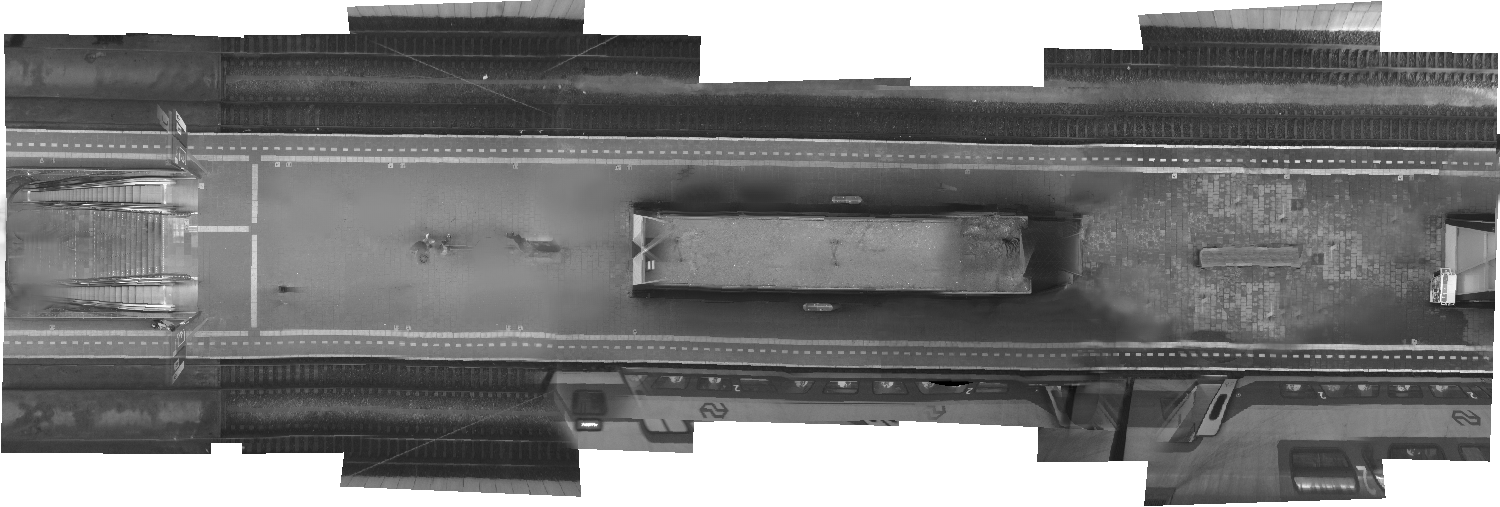

In [12]:
dh.fetch_background_image_from_path(configuration['plattegrond'])
dh.bg # Display the background image

In the cell below we create a plot of the same trajectories as before on top of the background image. Additionally we plot the first observation of every trajectory (its origin) as a green circle and the last observation (its destination) as a red cross.

Text(0, 0.5, 'y [mm]')

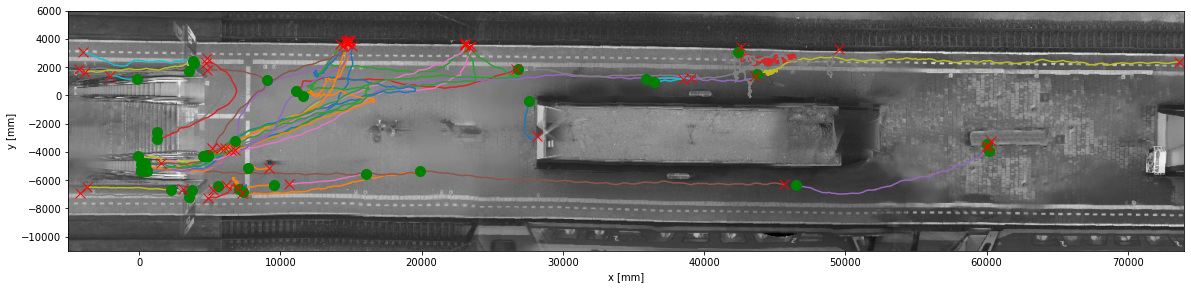

In [13]:
fig, ax = plt.subplots(figsize = (20, 5))

# Plot trajectories
plot_df.groupby('tracked_object').apply(lambda x : ax.plot(x.x_pos,x.y_pos));

# Plot origins and destinations
origins = plot_df.groupby('tracked_object').agg({'x_pos':'first', 'y_pos':'first'})
destinations = plot_df.groupby('tracked_object').agg({'x_pos':'last', 'y_pos':'last'})
plt.plot(origins.x_pos, origins.y_pos, 'og', ms = 10)
plt.plot(destinations.x_pos, destinations.y_pos, 'xr', ms = 10)


# Plot the background image
bg_params = configuration["background_parameters"][next(iter(configuration['background_parameters']))]
plt.gca().imshow(dh.bg, extent = [
                    bg_params["x_min"],bg_params["x_max"],
                    bg_params["y_min"],bg_params["y_max"],
                ], alpha = 1)

# Set the axis
ax.set_aspect('equal')
plt.xlim(-5000, 74000)
plt.ylim(-11000, 6000)

# Set axis labels
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')

## Heatmap

We can plot a heatmap to see which place of the area is most frequently used by the pedestrians.

Text(0, 0.5, 'y [mm]')

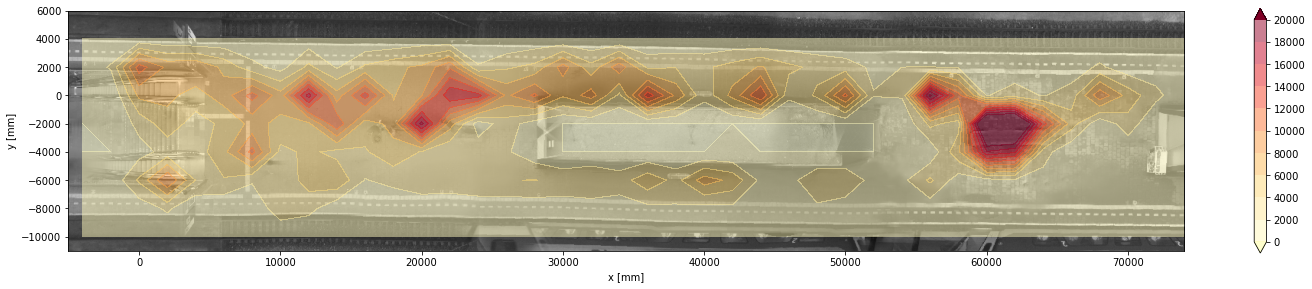

In [31]:
import numpy as np
fig, ax = plt.subplots(figsize = (25, 5))

# Create histogram of the x and y positions
binsx = np.arange(-5000, 76000, 2000)
binsy = np.arange(-11000, 7000, 2000)
hist, binsx, binsy = np.histogram2d(dh.df.x_pos, dh.df.y_pos, bins = (binsx, binsy))

# Plot the histogram
binx_middle = (binsx[1:] + binsx[:-1]) / 2
biny_middle = (binsy[1:] + binsy[:-1]) / 2
X, Y = np.meshgrid(
    binx_middle,
    biny_middle
)
vmin, vmax = 0, 20000
levels = np.linspace(vmin,vmax,11)
cs = ax.contourf(X, Y, hist.T,
                cmap = 'YlOrRd', #shading = 'auto',
                extend = 'both',
                corner_mask = False,
                zorder = 10, 
                levels = levels,
                vmin = vmin, vmax = vmax,
                alpha = 0.5)

# Plot a colorbar
cbar = (
        plt.colorbar(
            cs, ax = ax,
            shrink = 0.9,
            ticks = levels
            )
)

# Plot the background image
plt.gca().imshow(dh.bg, extent = [
                    bg_params["x_min"],bg_params["x_max"],
                    bg_params["y_min"],bg_params["y_max"],
                ], alpha = 1)

# Set the axis
ax.set_aspect('equal')
plt.xlim(-5000, 74000)
plt.ylim(-11000, 6000)

# Set axis labels
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')

## Platform occupation over time

To use the time of the observations we need some preprocessing. We need to convert the UNIX timestamps into datetime instances, set the correct timezone, and sort the dataframe.

In [32]:
# Import pandas library
import pandas as pd

# Convert to datetime
dh.df['datetime'] = pd.to_datetime(dh.df.date_time_utc, unit='ms')

# First set timezone to UTC
dh.df['datetime'] = dh.df.datetime.dt.tz_localize('UTC') 

# Convert to CET
dh.df['datetime'] = dh.df.datetime.dt.tz_convert('Europe/Berlin') 

# Sort values
dh.df = dh.df.sort_values('date_time_utc')

In [33]:
dh.df.head()

,date_time_utc,tracked_object,y_pos,x_pos,datetime
0,1.682662e+12,13826589,-414.0,27576.0,2023-04-28 08:00:00+02:00
1,1.682662e+12,13826715,-5347.0,19918.0,2023-04-28 08:00:00+02:00
2,1.682662e+12,13826896,-68.0,11596.0,2023-04-28 08:00:00+02:00
3,1.682662e+12,13826897,284.0,11137.0,2023-04-28 08:00:00+02:00
4,1.682662e+12,13826907,-3224.0,6792.0,2023-04-28 08:00:00+02:00


We can plot the platform occupation over time. Therefore, we add a column with the number of objects in each timeframe. 

Text(0, 0.5, 'Pedestrians in frame')

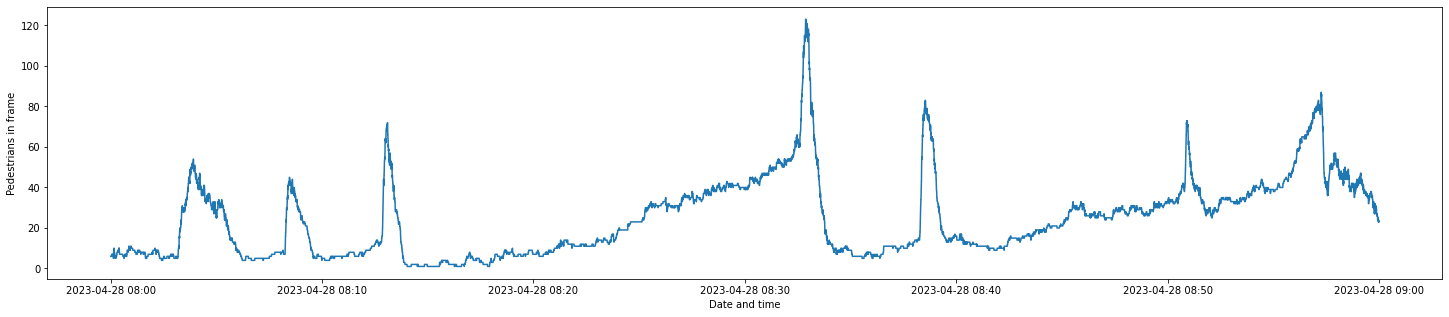

In [35]:
# Format the datetimes on the x-axis
plt.rcParams["date.autoformatter.minute"] = "%Y-%m-%d %H:%M"

# Add a column with the number of objects in the frame
dh.df['frame_objs'] = dh.df.groupby('date_time_utc').tracked_object.transform('size')

# Plot the platfrom occupation
fig, ax = plt.subplots(figsize = (25, 5))
ax.plot(dh.df.datetime, dh.df.frame_objs)
ax.set_xlabel('Date and time')
ax.set_ylabel('Pedestrians in frame')